# RL coursework, part III (25 pts total)
---

**Name:** Yuan Lu

**SN:** 20114649

---

**Due date:** *April 10th, 2025*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part3.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

----
**Reminder of copyrights**

Copyrights protect this code/content and distribution or usages of it (or parts of it) without permission is prohibited. This includes uploading it and usage of it in training in any LLMs systems.

# The Assignment

### Objectives

You will be guided through the implementation of a full deep reinforcement learning agent.

## Setup

Run all the cells in this section, but do not modify them.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)

## Helpers

# A) Actor-critics

You are going to implement an Actor-critic agent that updates a policy parametrised as a deep neural network.

The agent learns online from a single stream of experience, updating the parametes of its policy after each transition in the environment.

### Install packages

In [2]:
!pip install -U jaxlib==0.4.33 "jax[cuda12]"
!git clone https://github.com/deepmind/bsuite.git
!pip install bsuite/

INFO: pip is looking at multiple versions of jax[cuda12] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax[cuda12] to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.3 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.5.1
    Uninstalling jax-cuda12-pjrt-0.5.1:
      Su

### Imports

In [3]:
from bsuite.environments import catch
import jax
import jax.numpy as jnp

### Plotting

In [4]:
def plot_learning_curve(list_of_episode_returns):
  """Plot the learning curve."""
  plt.figure(figsize=(7, 5))

  def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

  smoothed_returns = moving_average(list_of_episode_returns, 30)
  plt.plot(smoothed_returns)

  plt.xlabel('Average episode returns')
  plt.xlabel('Number of episodes')

  ax = plt.gca()
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(True)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')

### Neural networks

You will use JAX to define a network parametrising:

* The values of each state $v(s)$.
* The action preferences in each state $\{p_i(s)\}_{i\in\{1, ..., |A|\}}$ (you can think of and implement the preferences $\mathbf{p}(s)$ as a vector output with $|A|$ elements).

There are many neural network libraries available that can be used to create networks in jax.  But here we will keep things relatively simple and just define our own network.

Specifically, we will define a `network` function returns a **scalar** value `v` and a **vector** of preferences `p`, which will define the policy of the agent.  This function will take as its inputs a dictionary `params` of parameters that we will update, which will contain all the parameters of the network.

A lot of the boilerplate code has been written for you.  You will have to implement some functions as indicated in the questions below.

### Q1 [3 marks]

Create the parameters and define the forward pass of the neural network. The `network` function must look as follows when we call it:
`v, p = network(params, observation)`

The network should be implemented as follows:
* The inputs are a dictionary of parameters `params`, and a tensor (a `jnp.array`) called `observation`.
* We reshape the observation into a flat vector `flat_observation`.
* We compute a hidden representation
`h = relu(flat_observation.dot(w) + b)`, where the weights and biases are given in the input dictionary as `w = params['w']` and `v = params['b']` (and analogously for all other parameters), and where `relu(x)` is a 'rectifier linear unit', which computes $\max(x, 0)$ elementwise (you can use `jax.nn.relu(x)` to implement this, if you want).
* We compute a vector of action preferences as a linear function of `h`, such that `p = h.dot(w_p) + b_p`.
* Similarly, we compute a scalar state value `v` as a linear function of `h`.
* Finally, we return the scalar value and vector preferences as a tuple.

Further, make sure that:
* The hidden representation should be a vector of 50 elements.
* The action preferences should be a vector of 3 elements (one per each available action).
* The value should be a scalar (not a vector with one element).
* All parameters should be initialised randomly as follows:
```
rng_key, param_key = jax.random.split(rng_key)
parameter = jax.random.truncated_normal(param_key, -1, 1, shape)
```
where `shape` is the relevant shape for this `parameter` (e.g., `parameter` is `w` or `b`, etc.).  The first line is important: it 'splits' the random key into a temporary random key `param_key` that should **only** be used for this parameter, and a new `rng_key` that can be split again later for the next parameters, etc.


In [5]:
def create_parameters(rng_key, observation):
  """Creates and returns a dictionary of network parameters.

  Parameters:
    rng_key: a JAX random key.
    observation: a JAX array representing a sample observation, used to determine the input size.

  Returns:
    params: a dictionary containing the following keys:
        'w'   : weights for the hidden layer (shape: [input_dim, 50])
        'b'   : biases for the hidden layer (shape: [50])
        'w_p' : weights for the action preference layer (shape: [50, 3])
        'b_p' : biases for the action preference layer (shape: [3])
        'w_v' : weights for the state value layer (shape: [50, 1])
        'b_v' : biases for the state value layer (shape: [1])
  """
  # We first flatten the observation so we know its size.
  in_dim = jnp.size(observation)
  hidden_dim = 50
  num_actions = 3

  params = {}
  # 1) Hidden-layer weights and bias:
  rng_key, param_key = jax.random.split(rng_key)
  params['w'] = jax.random.truncated_normal(
      param_key, lower=-1, upper=1, shape=(in_dim, hidden_dim))

  rng_key, param_key = jax.random.split(rng_key)
  params['b'] = jax.random.truncated_normal(
      param_key, lower=-1, upper=1, shape=(hidden_dim,))

  # 2) Action-preferences head weights/bias:
  rng_key, param_key = jax.random.split(rng_key)
  params['w_p'] = jax.random.truncated_normal(
      param_key, lower=-1, upper=1, shape=(hidden_dim, num_actions))

  rng_key, param_key = jax.random.split(rng_key)
  params['b_p'] = jax.random.truncated_normal(
      param_key, lower=-1, upper=1, shape=(num_actions,))

  # 3) Value head weights/bias:
  rng_key, param_key = jax.random.split(rng_key)
  params['w_v'] = jax.random.truncated_normal(
      param_key, lower=-1, upper=1, shape=(hidden_dim, 1))

  rng_key, param_key = jax.random.split(rng_key)
  params['b_v'] = jax.random.truncated_normal(
      param_key, lower=-1, upper=1, shape=(1,))

  return params

In [6]:
def network(params, observation):
  """Performs a forward pass through the network.

  Parameters:
    params: a dictionary of network parameters.
    observation: a JAX array representing the current state.

  Returns:
    v: a scalar value estimate of the state.
    p: a vector of action preferences.
  """
  # Flatten the observation
  flat_observation = jnp.reshape(observation, [-1])

  # Hidden representation
  h = jax.nn.relu(flat_observation @ params['w'] + params['b'])

  # Action preferences
  p = h @ params['w_p'] + params['b_p']

  # Scalar value
  v = h @ params['w_v'] + params['b_v']    # shape: (1,)
  v = jnp.squeeze(v)  # Make it a scalar instead of [scalar]
  return v, p

### Choosing actions

A critical component of an actor-critic agent is a (stochastic) policy, mapping `observations` to `actions`.

In deep RL, this mapping is conventionally parametrised by a deep neural network.

Here we provide a softmax policy parametrised by the neural network above (i.e., using the `network` function). The function has signature `action = softmax_policy(parameters, key, obs)`, taking the current network parameters `parameters`, a JAX random `key` and the current `observation`.

### Softmax definition

In [7]:
#DO NOT MODIFY
# Functions to perform random sampling in JAX (e.g. those in `jax.random`) take
# a random key as input, and they are deterministic function of such a key. In
# general, in a JAX program you need to use the `jax.random.split` function to
# generate new random keys before every new sampling. The run loop that runs the
# experiment later on will split and provides the keys for the function defined
# here.

# Note that we 'jit' the function.  This means the function will be compiled,
# which will make it run faster. This does also suppress print statements, so if
# you are debugging and want to print please comment out the `@jax.jit` line,
# but don't forget to put it back before running the experiment below, and
# especially before submitting your assignment.

@jax.jit
def softmax_policy(parameters, key, obs):
  """Sample action from a softmax policy."""
  _, p = network(parameters, obs)
  return jax.random.categorical(key, p)

### Learning values and policies

An actor-critic agent requires to update the parameters of the network so as to simultaneously improve the value predictions and the policy.

In the next section you will define the gradient updates for each of these two components.

### Q3 [4 marks]

Implement a function to compute a stochastic estimate of the policy gradient from a 1 step transition in the environment.

* You will use $R_{t+1} + \gamma v(S_{t+1})$ as an estimate of $q_{\pi}(S_t, A_t)$
* You will use $v(S_{t})$ as a baseline to reduce the variance of the updates.

In the code we actually use names `obs_tm1`, `a_tm1` (where `tm1` stands for '$t$ minus one') for the observation and action at time $t-1$, and `r_t`, `discount_t`, `obs_t` for the reward, discount, and observation at time $t$. So the code is offset a single time step in terms of naming as compared to the typical mathematical formulations.  This is just a naming convention, and should not impact the algorithm.

The function below must therefore have signature `grads = policy_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * `parameters`: the parameters of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and discount `discount_t` and observation `obs_t`, as obsesrved after taking action `a_tm1`.

This function should return a stochastic estimate of the policy gradient, where `grads` has the same structure as `parameters` and contains an estimate of the gradient of the expected episodic return wrt to each parameter.

The policy-gradient estimate should use bootstrapping, using the value estimates that can be gotten using the saame `parameters` as used for the policy.  So the output of this function can be used in a one-step actor-critic update.

### Jax hint:
Note that you can use `jax.grad(f)` to get the gradient of any (pure) jax function with a scalar output.  For instance, consider:

        def f(w, x, y):
          # w, x, and y are all vectors
          return jnp.sum(w*x + y)

        df = jax.grad(f)
    
then calling `df(w, x, y)` will give the gradient of the output of `f(w, x, y)` with respect to the first input argument --- here called `w`. You can use this new function `df` as just a normal function. For instance, it can be called from other functions, as usual.

Run the cell below to see a concrete example in action.  Note that `df(w, x, y)` in the example below evaluates to the same values as `x`.  This is correct, because the gradient of `f` with respect to `w` is indeed `x`.

In [8]:
def f(w, x, y):
  return jnp.sum(w*x + y)

df = jax.grad(f)

w = jnp.array([1., 2.])
x = jnp.array([3., 5.])
y = jnp.array([7., 11.])

print(f'f(w, x, y):  {f(w, x, y)}')
print(f'df(w, x, y): {df(w, x, y)}')

f(w, x, y):  31.0
df(w, x, y): [3. 5.]


### Jax hint:
You network will have a dictionary `params` as input.  Suppose you have a function that computes the output of a network, and then uses this to do some stuff, and you want the gradient of that new function.  That is, suppose your code looks something like this:

        # Define network
        def network(params, ...):
          ...

        # Define a new function
        def function(params, x, y, z, ...):
           ...
           output = network(params, x)
           ...
           return ...(some function of output)...        

Now,
```
grads = jax.grad(function)(params, x, y, z, ...)
```
will give the gradients of `function` with respect to the first input argument, `params`.  These gradients `grads` will have exactly the same shape as the input argment `params`.

But note that we cannot do things like `params + grads`, because `params` and `grads` are both dictionaries, not just `jnp.array`s.  Instead, we could explicitly traverse the dictionary.  But it is perhaps even easier to use in-built tree utils in Jax.  Specifically, the util `jax.tree_util.tree_map(f, x, y)` applies function f to all the elements in `x` and `y`.

For instance, to add the gradients to the parameters, we can use:
```
def add_gradient_to_weight(w, g, learning_rate=0.1):
  return w + learning_rate * g
new_params = jax.tree_map(add_gradient_to_weight, params, grads)
```
The above snippet would apply the function `add_gradient_to_weight` to the elements in `params` and `grads`, here adding each element in `grads` to each corresponding element in `weights` (in this case using the default learning rate `learning_rate=0.1`, as specified in the function definition).


In [9]:
@jax.jit
def policy_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    """
    Computes a stochastic estimate of the policy gradient using a one-step actor–critic update.

    Inputs:
      parameters   : network parameters
      obs_tm1      : observation at time t-1 (when action a_tm1 was selected)
      a_tm1        : action taken at time t-1
      r_t          : reward received after taking a_tm1
      discount_t   : discount factor at time t
      obs_t        : observation at time t (after taking action a_tm1)

    The pseudo-loss is defined as:
      loss = - log π(a_tm1|obs_tm1) * (r_t + discount_t * v(obs_t) - v(obs_tm1))

    Its gradient (when multiplied by -1) yields:
      ∇ log π(a_tm1|obs_tm1) * (r_t + discount_t*v(obs_t) - v(obs_tm1))

    which is our desired policy gradient estimate.
    """
    def loss_fn(params):
        # Compute value and preferences at the previous observation.
        v_tm1, p_tm1 = network(params, obs_tm1)
        # Compute value for the next observation; stop gradients here
        v_t, _ = network(params, obs_t)
        # Define target as r_t + γ * v(obs_t), with no gradient flowing through v(obs_t)
        target = r_t + discount_t * jax.lax.stop_gradient(v_t)
        # Compute the advantage using v(obs_tm1) as baseline (also stopping its gradient)
        advantage = target - jax.lax.stop_gradient(v_tm1)
        # Compute log probabilities from the preference logits
        log_probs = jax.nn.log_softmax(p_tm1)
        log_prob = log_probs[a_tm1]
        # The pseudo-loss is -log_prob * advantage
        return -log_prob * advantage

    # Compute the gradient of the loss with respect to parameters
    grads = jax.grad(loss_fn)(parameters)
    # Return the negative of that gradient so that a gradient descent step performs policy ascent.
    return jax.tree_util.tree_map(lambda g: -g, grads)


### Q4 [4 marks]

Implement a function to compute a TD(0) update for the parameters of the value function.

It must have signature `td_update = value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the current parameters `parameters` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t`
  * and the following observation `obs_t`
* Returns a stochastic TD(0) semi-gradient update: `td_update` has the same structure as `parameters`. This contains a stochastic estimate of the negative semi-gradient of the expected value prediction loss: a TD(0) update.

In [10]:
@jax.jit
def value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    """
    Returns the negative semi-gradient of the 1-step TD(0) loss:
      L(θ) = 0.5 * (r_t + γ * v(obs_t)_stop_grad - v(obs_tm1))^2,
    with no gradient flowing through v(obs_t).
    """
    def loss_fn(params, obs_tm1, a_tm1, r_t, discount_t, obs_t):
        # Compute the value for the next observation, then freeze its gradient.
        v_t, _ = network(params, obs_t)
        target = r_t + discount_t * jax.lax.stop_gradient(v_t)
        # Compute the current state's value.
        v_tm1, _ = network(params, obs_tm1)
        # Squared TD error.
        return 0.5 * (target - v_tm1) * v_tm1#** 2

    # Compute the gradient of the loss with respect to the parameters.
    grads = jax.grad(loss_fn)(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)

    # Return the negative gradient so that a gradient descent update reduces the TD error.
    return jax.tree_util.tree_map(lambda g: g, grads)


### Updating shared parameters

The policy gradient identifies the direction of change in the parameters that most steeply improve the policy.
The value update identifies the direction of change in the parameters that improves the value predictions (according to TD).

However, the value and policy share some of the parameters of the network.  How do we combine the two gradient updates?

In this assignment, we simply sum the policy and value components.
The function that combines the two gradients is implemented for you in the cell below.  Note the use of `jax.tree_map` to facilitate adding the structured parameters.

In [11]:
@jax.jit
def compute_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  pgrads = policy_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  td_update = value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_util.tree_map(lambda pg, td: pg + td, pgrads, td_update)

### Optimisation

In deep learning, gradient updates are typically rescaled and modifed to avoid taking too large a step on a single update (e.g., due to large variance), and to facilitate the optimisation process (it turns out raw stochatic gradients are often not the most effective for updating neural networks).

For instance given a candidate gradient update $\nabla$ we may update our parameters $\theta$ by;
$$\Delta \theta = \theta + \alpha * \nabla\,,$$
where $\alpha$ is a small number between 0 and 1 (e.g., $\alpha=0.01$ or $\alpha=0.001$), referred to as `step_size` or `learning_rate`

The gradients with respect to each weight of a neural network may however have very different magnitudes. This can make it hard to set a suitable learning rate $\alpha$.

In deep learning, and deep RL, we typically use adaptive learning rates, for instance by rescaling each component of the gradient using statistics tracking the typical size of the updates to that weight. Then the entire update is rescaled using a global `learning_rate` $\alpha$.


### Q5 [2 marks]

A popular approach to adaptive gradient rescaling was introduced by the `Adam` algorithm.
This algorithm implements the following procedure before applying each update:
* Increase an update counter $k \gets k+1$ (starting at k=0 before any updates),
* Update the first moment of each gradient component $\mu \gets (1 - \beta_1) g + \beta_1 \mu$ where $g$ is the latest stochastic gradient, where $\beta_1$ is a parameter for the moving average.
* Update the second moment of each gradient component $\nu_i = (1 - \beta_2) g_i ^ 2 + \beta_2 \nu_i $ where $g$ is the latest gradient update, where $\beta_2$ is a parameter for the moving average.
* Use the following update to update the weights:
$$\Delta w = \alpha \frac{\mu / (1 - \beta_1 ^ {k})}{\epsilon + \sqrt{\nu / (1 - \beta_1 ^ {k})}}$$
* $\alpha$ is a global `learning rate`
* $\beta_1$ and $\beta_2$ define a soft horizon for the per-weight statistics.
* $\epsilon$ makes the rescaling more robust to numerical issues.

(See [Kingma et al, 2014](https://arxiv.org/abs/1412.6980) for details, if you are interested.)

In the next cell define a pair of functions (`opt_init`, and `opt_update` --- in each case `opt` is short for 'optimiser'), where:

The `opt_init` function has signature `opt_state = opt_init(parameters)`.
* Takes the network parameters as inputs
* Initialises an `optimiser state` holding the per weight statistics.

The `opt_update` function has signature `updates, opt_state = opt_update(grads, opt_state)`.
* Takes a `gradient` and an `optimisers state`,
* and returns the transformed gradient and the updated `optimiser state`.

The optimiser state `opt_state` should contain:
* The first-order momentum $\mu$, as updated with a moving-average-parameter $\beta_1$ which we call `b1` in the code.
* The first-order momentum $\nu$, as updated with a moving-average-parameter $\beta_2$ which we call `b2` in the code.

We will ignore the initial correction Adam typically uses, and will instead use the simpler transformation:
$$\Delta w = \alpha \frac{\mu}{\epsilon + \sqrt{\nu}}$$

Set the algorithm's hyper-parameters to $\alpha=0.003$, $\beta_1=.9$ and $\beta_2=.999$, $\epsilon=10^{-4}$.  You are allowed to hard-code these in, or make them configurable (e.g., pass them as additional arguments to `opt_update`, which is better if you want to play around, of course).  Set the initial moving averages to zero for $\mu$ and one for $\nu$.  E.g.,

        mu = jax.tree_map(jnp.zeros_like, parameters)

In [12]:
def opt_init(parameters):
  """
  Initialize the optimizer state (mu, nu) for Adam.
  mu is the first-moment estimate, nu is the second-moment estimate.
  We'll start mu at 0, nu at 1 as suggested.
  """
  mu = jax.tree_util.tree_map(jnp.zeros_like, parameters)
  nu = jax.tree_util.tree_map(jnp.ones_like, parameters)
  k = jnp.array(0)
  return (mu, nu, k)

@jax.jit
def opt_update(grads, opt_state):
  """
  Given the raw gradients and the optimizer state, return the (transformed) updates
  and the new optimizer state.  We implement a simplified Adam:
      mu     = b1 * mu + (1-b1) * g
      nu     = b2 * nu + (1-b2) * (g^2)
      update = alpha * [mu / sqrt(nu + eps)]
  """

  mu_prev, nu_prev, k_prev = opt_state
  beta1, beta2 = 0.9, 0.999
  alpha, eps = 0.003, 1e-4

  mu_new = jax.tree_util.tree_map(lambda m, g: beta1 * m + (1 - beta1) * g, mu_prev, grads)
  nu_new = jax.tree_util.tree_map(lambda v, g: beta2 * v + (1 - beta2) * (g ** 2), nu_prev, grads)
  k_new = k_prev + 1

  updates = jax.tree_util.tree_map(lambda m, v: alpha * m / (eps + jnp.sqrt(v)), mu_new, nu_new)
  return updates, (mu_new, nu_new, k_new)

### Run experiments

Run the cell below to show the performance of the resulting agent.

You may also use this section for debugging your implementations.

Note however, that most functions are `jitted` for performance,
* either using the `@jax.jit` decorator in the function definition
* or calling explicitly `fn = jax.jit(fn)`

When jitting, the code is compiled on the first time the function is executed
* and execution is much faster on subsequent calls.
* a notable side effect is that print statements in a jitted function will only execute on the first execution of the function.
* to drop into a debugger or print on each function execution you will have to disable the `@jax.jit` annotations and jax.jit calls.

Training agent for 5000 episodes...


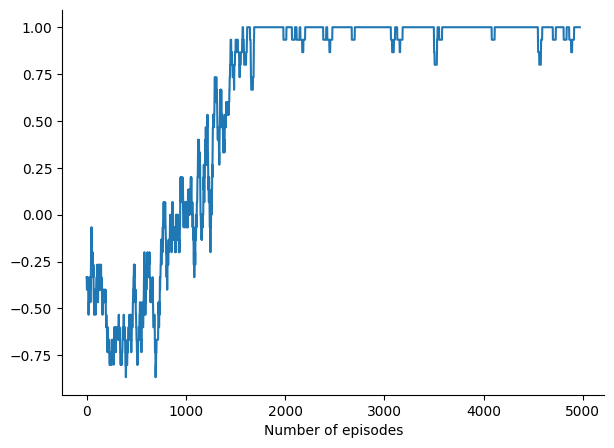

In [13]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 5000
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
parameters = create_parameters(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(parameters)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_util.tree_map(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = softmax_policy(parameters, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = softmax_policy(parameters, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount
    dJ_dtheta = compute_gradient(
        parameters, obs_tm1, a_tm1, r_t, discount_t,
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    parameters = apply_updates(parameters, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)

# B) An alternative update

You are going to implement a different kind of agent.

Like an actor-critic, it learns online from a single stream of experience, updating the parametes after each transition in the environment.

### Neural networks


The agent will reuse the same neural network we defined for the actor-critic:
* the scalar output will be trained via TD to estimate state values
* the vector preferences `p` will be updated according to a different rule.

### Choosing actions

As in actor-critics, the (stochastic) mapping from `observations` to `actions` depends on the vector of preferences `p` from the network.

### Q6 [2 marks]

The new agent's policy will have the signature `action = epsilon_greedy_policy(parameters, key, observation)`,
* Take as inputs the current network parameters `parameters`, a JAX random `key` and the current `observation`
* Return with probability `0.9` the greedy `action` with respect to the preferences `p`, ties must be broken at random.
* Return an action uniformly at random with probability `0.1`

In [14]:
@jax.jit
def epsilon_greedy_policy(parameters, key, observation):
    """Sample action from an epsilon-greedy policy."""
    _, p = network(parameters, observation)
    max_p = jnp.max(p)
    mask = p == max_p
    # Create logits where max entries are 0, others -infinity
    greedy_logits = jnp.where(mask, 0.0, -jnp.inf)
    # Split keys for decision and actions
    key, subkey = jax.random.split(key)
    do_greedy = jax.random.bernoulli(subkey, 0.9)
    key, subkey = jax.random.split(key)
    greedy_key, random_key = jax.random.split(subkey)
    # Greedy action: sample from max indices
    greedy_action = jax.random.categorical(greedy_key, greedy_logits)
    # Random action: uniform over all actions
    random_action = jax.random.randint(random_key, (), 0, p.shape[-1])
    # Choose action
    action = jnp.where(do_greedy, greedy_action, random_action)
    return action

### Q7 [3 marks]

The parameters $w_p$ of the preferences $p_{w_p}(s, a)$ will be update according to the following gradient-based update:

$$\Delta w_p = \alpha (R_{t+1} + \gamma v(S_{t+1}) - p(S_{t}, A_t)) \nabla p(S_t, A_t))$$

where `v` is the state value trained by TD as in the actor critic.

You musy implement this in the function `preference_gradient`, with the same signature as `policy_gradient`

In [15]:
@jax.jit
def preference_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    # Compute target = R + γ * v(S'), with v(S') from network but stop gradient
    v_t, _ = network(parameters, obs_t)
    target = r_t + discount_t * jax.lax.stop_gradient(v_t)

    # Get p(S_tm1, a_tm1)
    _, p_tm1 = network(parameters, obs_tm1)
    p_a = p_tm1[a_tm1]  # Fixed: use p_tm1 instead of p

    # Compute gradient of p(S_tm1, a_tm1) with respect to parameters
    def loss_fn(params):
        _, p_tm1_internal = network(params, obs_tm1)
        return p_tm1_internal[a_tm1]

    grad_p = jax.grad(loss_fn)(parameters)

    # Scale gradient by (target - p_a)
    delta = target - p_a
    scaled_grad = jax.tree_util.tree_map(lambda g: delta * g, grad_p)

    return scaled_grad


### Updating shared parameters

Just like in the actor critic the overall update to the parameters is a combination of two quantities:
* the new update we defined for the vector of preferences
* the same TD update to the scalar output that we used in the actor critic

In [16]:
@jax.jit
def compute_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  pgrads = preference_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  vgrads = value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_util.tree_map(lambda pg, td: pg + td, pgrads, vgrads)

### Optimisation

The gradient updates are rescaled using the same optimiser used for the actor-critic.

### Run experiments

Run the cell below to show the performance of the new agent.

Training agent for 5000 episodes...


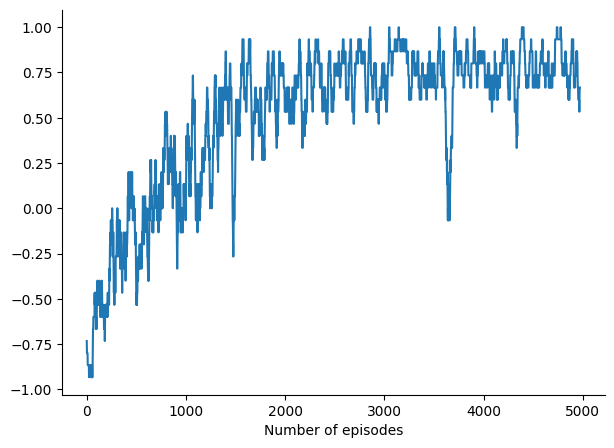

In [17]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 5000
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
parameters = create_parameters(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(parameters)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_util.tree_map(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = epsilon_greedy_policy(parameters, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = epsilon_greedy_policy(parameters, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount

    dJ_dtheta = compute_gradient(
        parameters, obs_tm1, a_tm1, r_t, discount_t,
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    parameters = apply_updates(parameters, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)

### Q8 [8 marks]

[2pts]: Run the optimisation in Part A) with both normal SGD (with a constant learning rate = 1e-3) and the ADAM optimisation you implemented. What can you observe? Explain any difference you might see. Please include both plots your answer (one for SGD and the other one for ADAM).

> When running our experiments, we observe that the ADAM optimizer results in a steadily improving agent performance, with the average episode return growing from around –1 to roughly 1. In contrast, when training with standard SGD (using a fixed learning rate of 1e-3), the performance remains erratic—returns tend to oscillate between –1 and –0.2 without a clear upward trend (see the figire below).

Here is a potential explainantion of what is happening:
- ADAM automatically adapts the learning rate for each parameter by keeping track of both the first moment (the mean of gradients) and the second moment (the uncentered variance). This means that each parameter update is scaled according to how noisy or consistent the gradient signal is.

- SGD applies a constant learning rate across all parameters. Without any mechanism to adapt the step size or account for the variance in the gradients, SGD can overshoot in some directions and take steps that are too small in others.

- In actor–critic architectures, the network jointly learns both the policy and the value function. Because these two components share parameters, any instability in the gradient updates can have a compounded effect on learning. ADAM’s ability to perform per-parameter learning rate adjustment allows it to balance these updates more effectively than SGD, so it has better convergence properties.

- The semi-gradient methods we use in TD-learning (for the critic) and the policy gradient estimates (for the actor) in it self sensitive to the scale of the updates. If the learning rate is not well-tuned—as is the case with a constant SGD learning rate—the combined update can fail to reduce the TD error or improve the policy, resulting in oscillatory or stagnant learning.



Training with opt_init for 5000 episodes...
Training with sgd_opt_init for 5000 episodes...


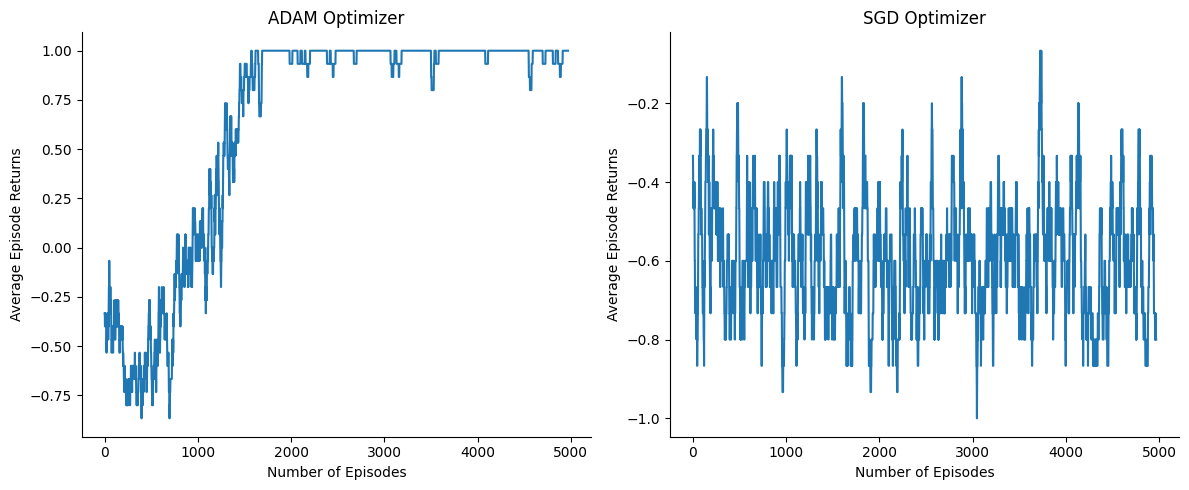

In [18]:
# @title Code for SGD
def sgd_opt_init(parameters):
  """
  Initialize the optimizer state for SGD.
  For SGD with a constant learning rate, no auxiliary state is needed,
  but we'll include an iteration counter for consistency.
  """
  k = jnp.array(0)
  return k

@jax.jit
def sgd_opt_update(grads, opt_state):
  """
  Given the gradients and the optimizer state, return the updates
  and the new optimizer state.

  We implement SGD with a constant learning rate:
      update = -lr * grad
  where lr = 1e-3.
  """
  lr = 1e-3
  k = opt_state
  k_new = k + 1
  updates = jax.tree_util.tree_map(lambda g: -lr * g, grads)
  return updates, k_new

@jax.jit
def compute_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  pgrads = policy_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  td_update = value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_util.tree_map(lambda pg, td: pg + td, pgrads, td_update)

def run_training(opt_update_fn, opt_init_fn, train_episodes, discount_factor):
    """
    A training loop that runs a fixed number of episodes using the provided optimizer.
    """
    print(f"Training with {opt_init_fn.__name__} for {train_episodes} episodes...")
    env = catch.Catch(seed=42)
    rng = jax.random.PRNGKey(44)
    rng, init_rng = jax.random.split(rng)
    sample_input = env.observation_spec().generate_value()
    parameters = create_parameters(init_rng, sample_input)
    opt_state = opt_init_fn(parameters)
    episode_returns = []

    for _ in range(train_episodes):
        episode_return = 0.0
        timestep = env.reset()
        obs_tm1 = timestep.observation
        rng, policy_rng = jax.random.split(rng)
        a_tm1 = softmax_policy(parameters, policy_rng, obs_tm1)
        while not timestep.last():
            new_timestep = env.step(int(a_tm1))
            rng, policy_rng = jax.random.split(rng)
            a_t = softmax_policy(parameters, policy_rng, new_timestep.observation)
            r_t = new_timestep.reward
            discount_t = discount_factor * new_timestep.discount
            grads = compute_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, new_timestep.observation)
            updates, opt_state = opt_update_fn(grads, opt_state)
            parameters = apply_updates(parameters, updates)
            episode_return += new_timestep.reward
            timestep = new_timestep
            obs_tm1 = new_timestep.observation
            a_tm1 = a_t
        episode_returns.append(episode_return)
    return episode_returns

train_episodes = 5000
discount_factor = 0.99

# Run training with ADAM
adam_returns = run_training(opt_update, opt_init, train_episodes, discount_factor)
# Run training with SGD
sgd_returns = run_training(sgd_opt_update, sgd_opt_init, train_episodes, discount_factor)

def plot_learning_curve_custom(adam_returns, sgd_returns):
    """Plot the learning curves for ADAM and SGD optimizers side by side."""
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot ADAM learning curve.
    smoothed_adam = moving_average(adam_returns, 30)
    axes[0].plot(smoothed_adam)
    axes[0].set_title('ADAM Optimizer')
    axes[0].set_xlabel('Number of Episodes')
    axes[0].set_ylabel('Average Episode Returns')
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[0].xaxis.set_ticks_position('bottom')
    axes[0].yaxis.set_ticks_position('left')

    # Plot SGD learning curve.
    smoothed_sgd = moving_average(sgd_returns, 30)
    axes[1].plot(smoothed_sgd)
    axes[1].set_title('SGD Optimizer')
    axes[1].set_xlabel('Number of Episodes')
    axes[1].set_ylabel('Average Episode Returns')
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].xaxis.set_ticks_position('bottom')
    axes[1].yaxis.set_ticks_position('left')

    plt.tight_layout()
    plt.show()

# Plot the learning curves.
plot_learning_curve_custom(adam_returns, sgd_returns)

[2pts]: What is the best asymptotic average return that can be achieved by the actor-critic agent described in `Part A)`? Can this be further improved, and if so: how? Explain your answer.

>  As time t $\rightarrow \infty$, the best asymptotic average return is 1, which corresponds to following the optimal policy in the Catch environment. In our experiments, the agent approaches this maximum reward (1) around 1700 episodes, indicating that there is limited room for improvement in terms of achievable return. However, improvements can still be made by fine-tuning the hyperparameters. For instance, lowering the learning rate and incorporating techniques such as Generalized Advantage Estimation (GAE) can further reduce the variance in the policy gradient updates, leading to more stable and efficient learning.


[2pts] What is the best asymptotic average return that can be achieved by the second agent described in `Part B)`? Can this be further improved, and if so: how? Explain your answer.

> The second agent follows an $\epsilon$-greedy policy. In our setup, the agent selects the greedy (optimal) action with probability 0.9 and a random action with probability 0.1. In the best-case scenario, when the greedy action always returns 1 and the random choice is uniformly over 3 actions, the average reward becomes:
$$
0.9 × 1 + 0.1 × [\frac{1}{3} × 1 + \frac{2}{3} \times (-1)] \approx 0.867
$$
This performance can be improved by reducing ε over time (i.e., annealing ε), so that the policy becomes more greedy as learning progresses. This would allow the agent to eventually approach an asymptotic return closer to 1 once it has sufficiently explored the environment.

[2pts] What quantity do the preferences `p` estimate in the second agent described in Part B?

> The preferences `p` are trained to approximate the action-value function, $q(s,a)$. In other words, they represent an estimate of the expected return obtained by taking action $a$ in state $s$ and then following the policy thereafter. This is reflected in the update rule:

$$
\Delta w_p = \alpha \Bigl( R_{t+1} + \gamma\,v(S_{t+1}) - p(S_t, A_t) \Bigr) \nabla p(S_t, A_t)
$$

which is analogous to a TD update for $q(s,a)$. Thus, in the second agent, the vector of preferences `p` effectively estimates the action-values.
